## All for logreg (ignoring SVM for now)
- bag of words for funsies - did not converge, let's ignore
- *get rid of stop words*
- *n-gramms*
- *chars*
- syntax (udpipe)
- *pos*
- split morphologically (kind of like bpe i guess)
- get rid of NER
- show EH during training


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

from utils import import_dataset, get_scores, classes, label2id
import pandas as pd
from numpy import mean, std
from tqdm.notebook import tqdm
import time
from datasets import load_dataset, concatenate_datasets
import pickle
CLASSES = classes

In [2]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.chunk import ne_chunk

In [3]:
def posify(data):
    return [' '.join([t[1] for t in pos_tag(word_tokenize(sent), tagset='universal')]) for sent in data]

def posify_word(data):
    return [' '.join([f'{t[0]}_{t[1]}' for t in pos_tag(word_tokenize(sent), tagset='universal')]) for sent in data]

In [4]:
def posify_separately(data):
    
    new_data = []

    for par in data: 
        new_par = []
        for sent in nltk.sent_tokenize(par): # 
            tags = nltk.pos_tag(nltk.word_tokenize(sent))
            tags = ' '.join([t[1] for t in tags])
            new_sent = sent + ' ' + tags
            new_par.append(new_sent)
            
        new_data.append(' '.join(new_par))
        
    return new_data

posify_separately(['Hi! My name is Dan.', 'My name is Jared. I am 18. I never fucking learned how to read.'])

NameError: name 'nltk' is not defined

In [49]:
# я хочу чтобы он заменял в предложении все сущности на их теги

def remove_ner(data):

    new_data = []
    
    for par in data:
        
        new_par = ''
        
        for sent in nltk.sent_tokenize(par): # !
            new_sentence = ''
            for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
                if hasattr(chunk, 'label'):
                    new_sentence += f'#{chunk.label()}'
                else:
                    new_sentence += chunk[0]
                new_sentence += ' '
            new_par += new_sentence
#             new_par += ' '
        
        new_data.append(new_par)
            
        
    # пробелы после знаков препинания...
    
    
    return new_data
            
remove_ner(['Hello! My name is Dan.', 'I live in London.'])

['#GPE ! My name is #PERSON . ', 'I live in #GPE . ']

In [5]:
def collect_dataset(seed, vectorizer=TfidfVectorizer(max_features=5000), save_vect=False, preproc=False):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    # main dataset
    dataset = import_dataset(seed)
    
    y_train = dataset['train']['labels']
    y_test = dataset['test']['labels']
    
    x_train = dataset['train']['text']  
    x_test = dataset['test']['text']
    
    if preproc=='pos':
        x_train = posify(x_train)
        x_test = posify(x_test)
    elif preproc=='pos_word':
        x_train = posify_word(x_train)
        x_test = posify_word(x_test)
    elif preproc == 'pos_sep':
        x_train = posify_separately(x_train)
        x_test = posify_separately(x_test)
    elif preproc == 'ner':
        x_train = remove_ner(x_train)
        x_test = remove_ner(x_test)
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')
    
    x_eh_test = vectorizer.transform(eh_dataset['train']['text'])
    y_eh_test = eh_dataset['train']['labels']
    
    if save_vect:
        with open('models/tfidf_vectorizer.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

In [42]:
def run_model(model, 
              title, 
              data=(),
              seed=13,
              matrix=True, 
              print_accuracy=True,
              collect_mistakes=False,
              test_eh=True):
    
    if not data:
        data = collect_dataset(seed)
    
    x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, _ = data
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    eh_pred = model.predict(x_eh_test)

    if test_eh:
        eh_accuracy = get_scores(eh_pred, y_eh_test, title='essay-history', matrix=True, print_=False)
        print('Accuracy on essays in history: ', eh_accuracy)

    accuracy = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_accuracy)
                
    out = {'accuracy':accuracy,
           'pred':pred}
                
                
    if collect_mistakes:
        mistakes = []
    
        for i in range(len(y_test)):
            t = y_test[i]
            p = pred[i]

            if t != p:
                mistakes.append((CLASSES[t], CLASSES[p], dataset['test'][i]['title'], dataset['test'][i]['text']))

        df = pd.DataFrame(mistakes, columns=['true', 'predicted', 'title', 'text'])
        out['mistakes'] = df
    
    return out

In [6]:
CLASSES

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

## Default

Accuracy on essays in history:  0.7164179104477612
Accuracy: 0.7516129032258064%
Training time: 1.2662584781646729 s


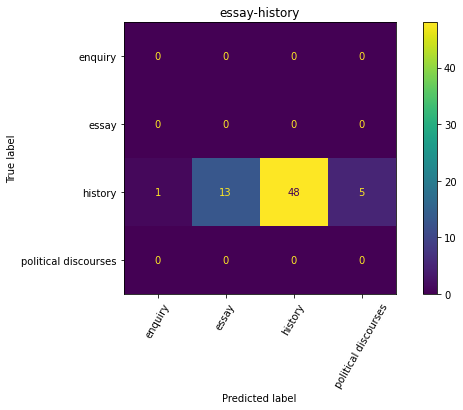

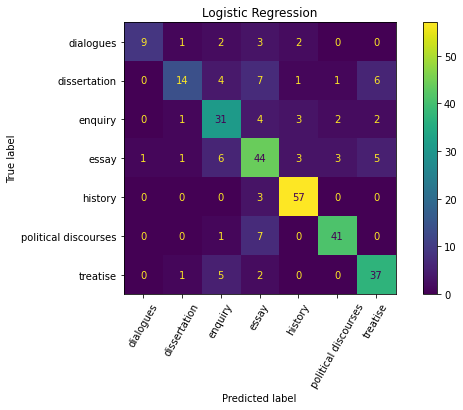

In [7]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

In [6]:
dataset = import_dataset(13)

In [13]:
sum([len(text.split()) for text in dataset['train']['text']]) + \
sum([len(text.split()) for text in dataset['test']['text']]) + \
sum([len(text.split()) for text in dataset['eval']['text']])

501454

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 2476
    })
    eval: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 309
    })
    test: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 310
    })
})

## Stop-words

Accuracy on essays in history:  0.5522388059701493
Accuracy: 0.7709677419354839%
Training time: 0.8745193481445312 s


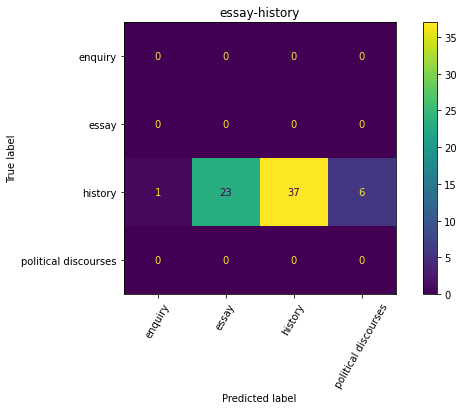

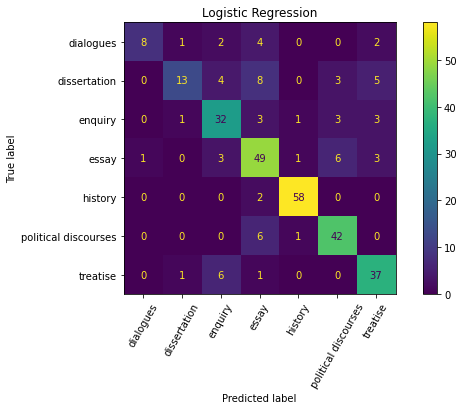

In [8]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## N-grams

Accuracy on essays in history:  0.7014925373134329
Accuracy: 0.7258064516129032%
Training time: 1.4512577056884766 s


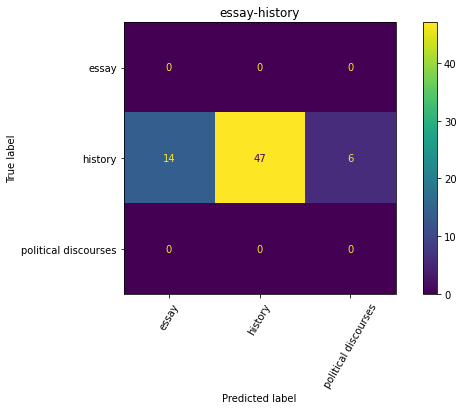

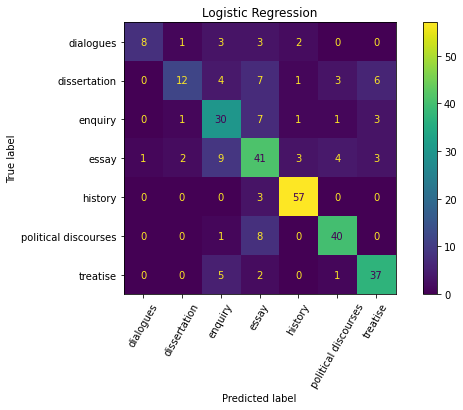

In [9]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.7014925373134329
Accuracy: 0.7258064516129032%
Training time: 1.6398570537567139 s


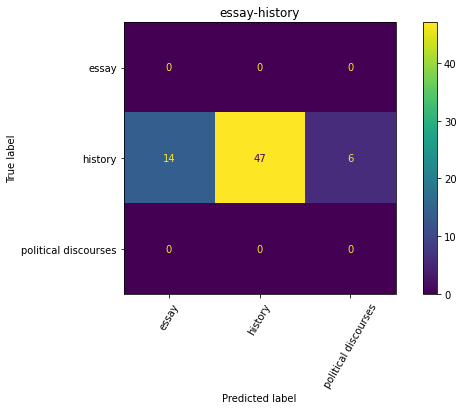

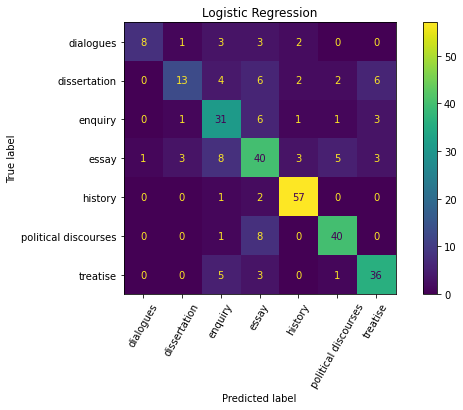

In [10]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.5671641791044776
Accuracy: 0.6161290322580645%
Training time: 1.2675528526306152 s


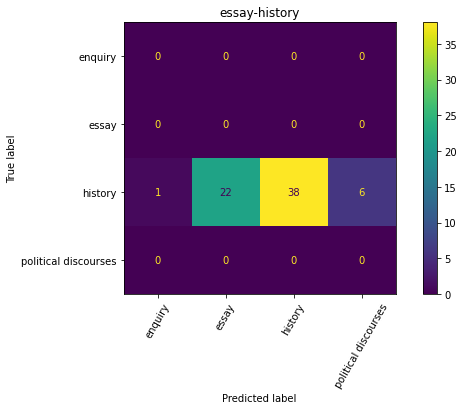

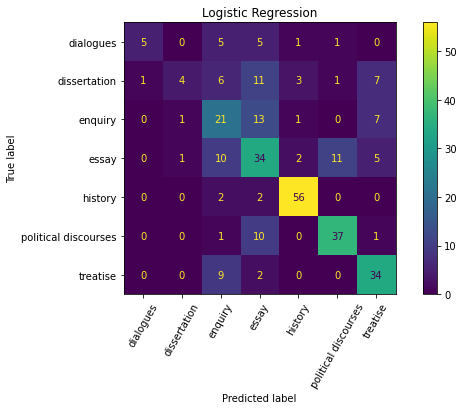

In [11]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.6268656716417911
Accuracy: 0.5774193548387097%
Training time: 14.90951657295227 s


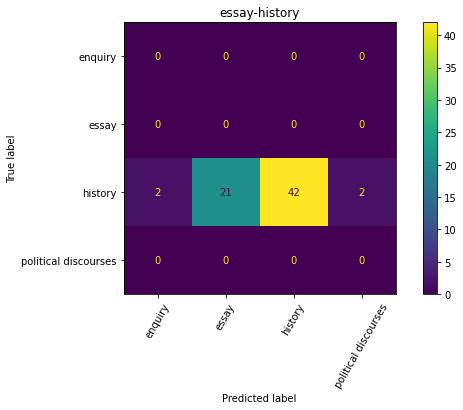

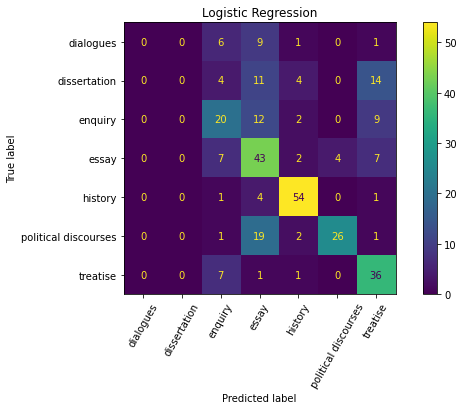

In [54]:
vectorizer = TfidfVectorizer(ngram_range=(3, 3))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## Char

Accuracy on essays in history:  0.6268656716417911
Accuracy: 0.4096774193548387%
Training time: 0.12454915046691895 s


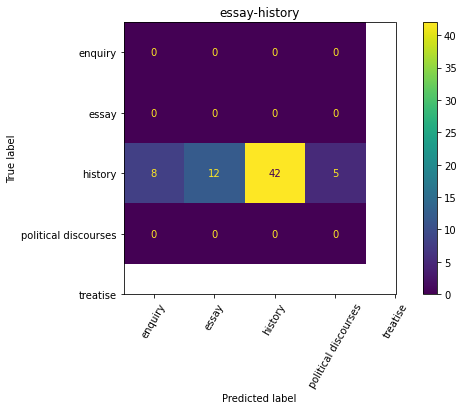

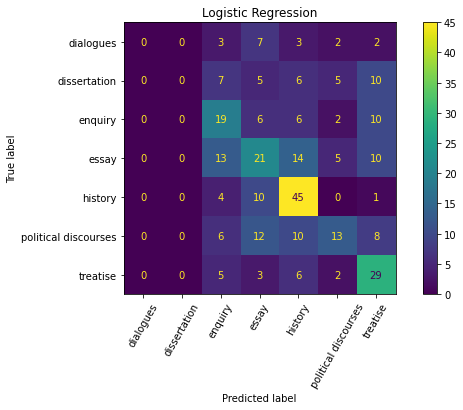

In [12]:
vectorizer = TfidfVectorizer(analyzer='char')
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.6119402985074627
Accuracy: 0.4129032258064516%
Training time: 0.09846711158752441 s


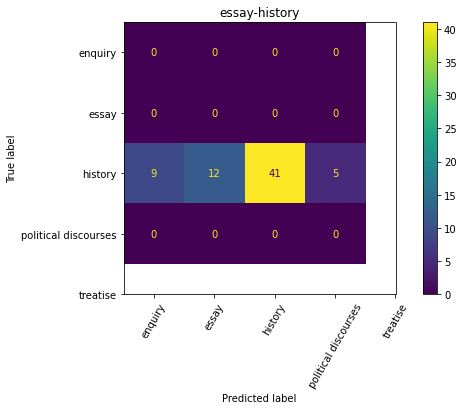

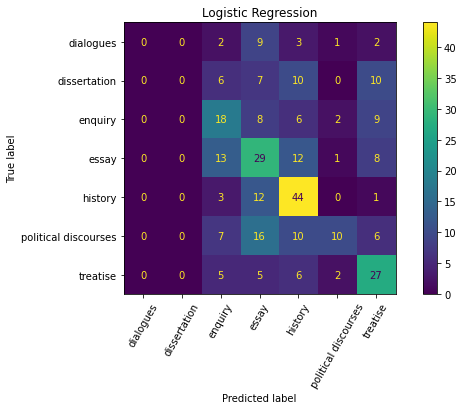

In [13]:
vectorizer = TfidfVectorizer(analyzer='char_wb')
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.7164179104477612
Accuracy: 0.7096774193548387%
Training time: 5.1169562339782715 s


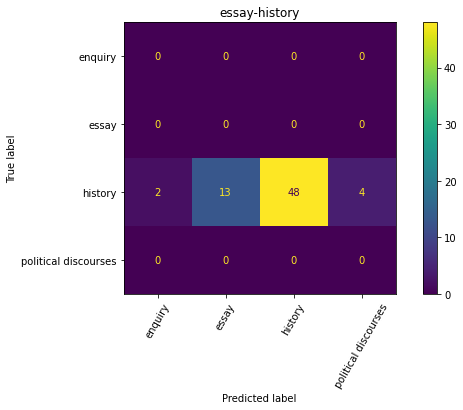

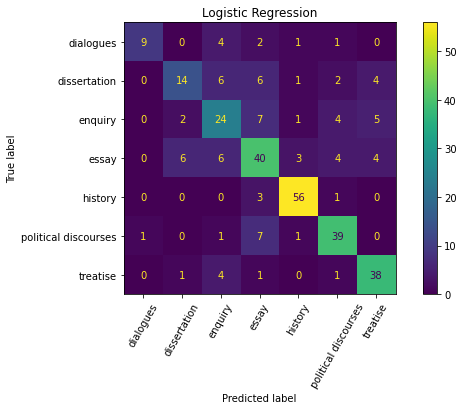

In [14]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 3))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.7164179104477612
Accuracy: 0.7387096774193549%
Training time: 6.929611444473267 s


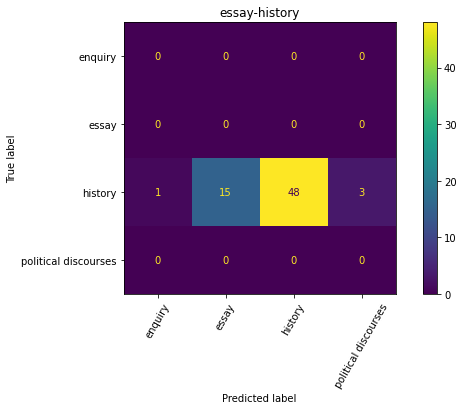

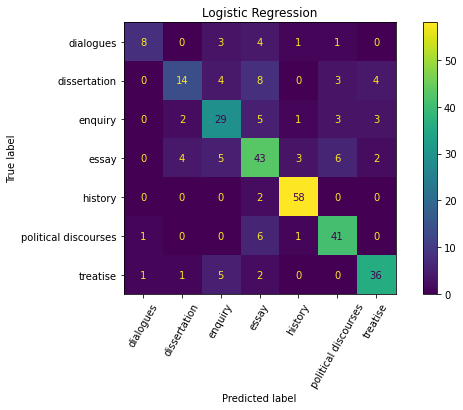

In [52]:
# Laippala 2021
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(4, 4))
data = collect_dataset(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## POS

Accuracy on essays in history:  0.0
Accuracy: 0.3193548387096774%
Training time: 0.11175775527954102 s


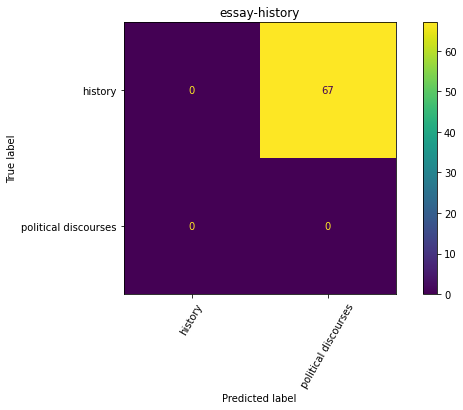

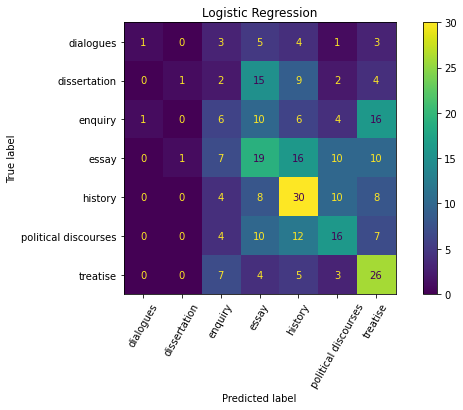

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)
# only pos
data = collect_dataset(13, vectorizer=vectorizer, preproc='pos')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.0
Accuracy: 0.7387096774193549%
Training time: 1.1445198059082031 s


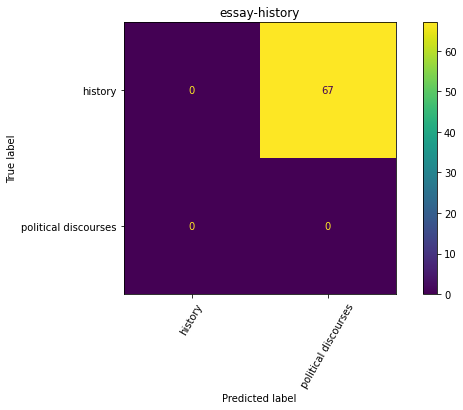

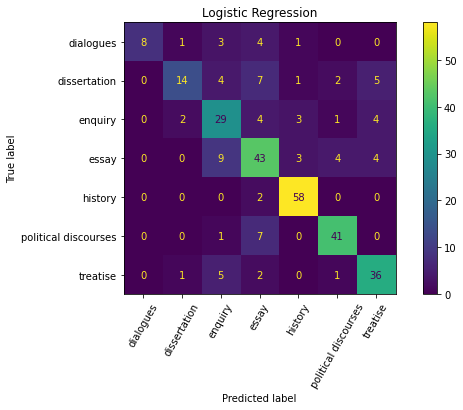

In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
# word_pos
data = collect_dataset(13, vectorizer=vectorizer, preproc='pos_word')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Accuracy on essays in history:  0.014925373134328358
Accuracy: 0.7032258064516129%
Training time: 2.3578474521636963 s


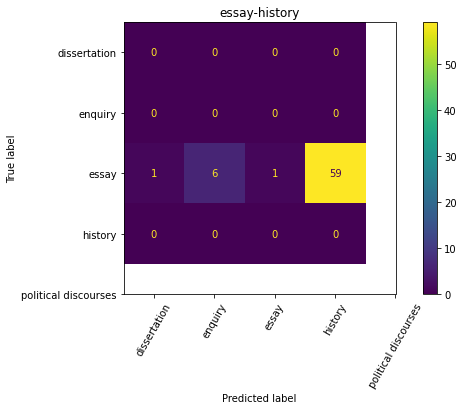

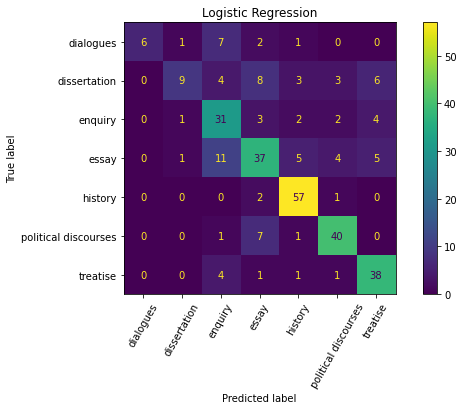

In [109]:
vectorizer = TfidfVectorizer(max_features=5000)
# sentence_tags
data = collect_dataset(13, vectorizer=vectorizer, preproc='pos_sep')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## NER

Accuracy on essays in history:  0.6716417910447762
Accuracy: 0.7516129032258064%
Training time: 1.8977491855621338 s


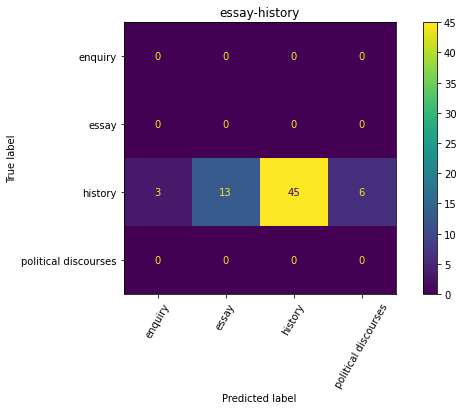

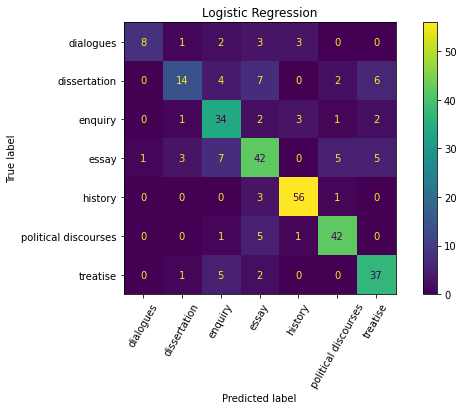

In [51]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset(13, vectorizer=vectorizer, preproc='ner')
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

## Train with EH

In [93]:
def collect_dataset_with_EH(seed, vectorizer=TfidfVectorizer(max_features=5000), save_vect=False, preproc=False):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    # main dataset
    dataset = import_dataset(seed)
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')

    eh_dataset = eh_dataset['train'].train_test_split(test_size=0.5)

    # это плохо, потму что не совсем понятно, какой лейбл надо указывать (эссе, политический дискурс?)
    # и мы тогда теряем некоторую точность
    def change_labels(example):
        example['labels'] = 3
        example['genre'] = 'essay'
        return example

    eh_dataset['train'] = eh_dataset['train'].map(change_labels)

    final = concatenate_datasets([eh_dataset['train'], dataset['train']])

    y_train = final['labels']
    y_test = dataset['test']['labels']
    
    x_train = final['text']  
    x_test = dataset['test']['text']
    
    
    if preproc=='pos':
        x_train = posify(x_train)
        x_test = posify(x_test)
    elif preproc=='pos_word':
        x_train = posify_word(x_train)
        x_test = posify_word(x_test)
    elif preproc == 'ner':
        x_train = remove_ner(x_train)
        x_test = remove_ner(x_test)
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    # здесь лейбл всё еще история
    x_eh_test = eh_dataset['test']['text']
    y_eh_test = eh_dataset['test']['labels']
    
    x_eh_test = vectorizer.transform(x_eh_test)
#     y_eh_test = y_eh_test
    
    if save_vect:
        with open('models/tfidf_vectorizer.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Accuracy on essays in history:  0.5588235294117647
Accuracy: 0.7580645161290323%
Training time: 1.482349157333374 s


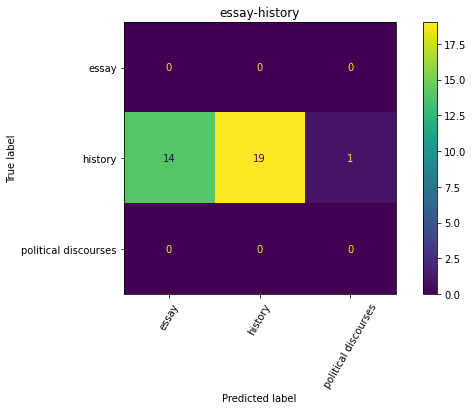

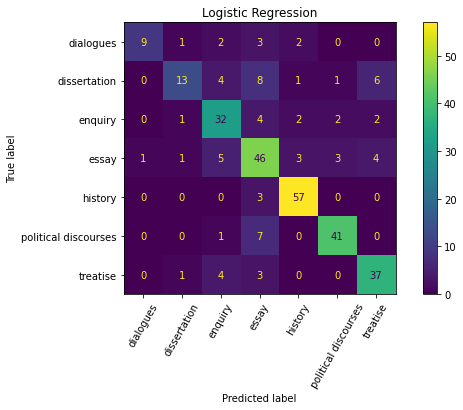

In [94]:
vectorizer = TfidfVectorizer(max_features=5000)
data = collect_dataset_with_EH(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Accuracy on essays in history:  0.3235294117647059
Accuracy: 0.7548387096774194%
Training time: 0.8208303451538086 s


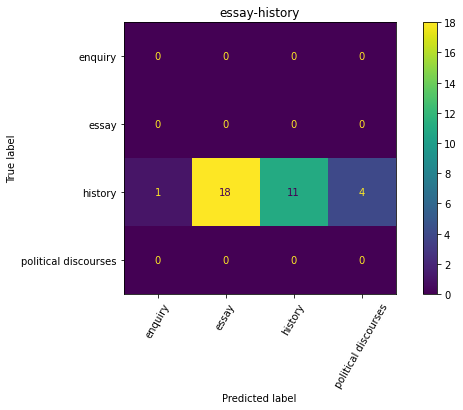

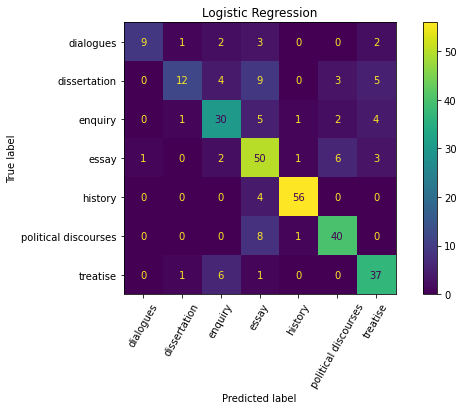

In [95]:
# + remove stop-words
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
data = collect_dataset_with_EH(13, vectorizer=vectorizer)
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression', data=data)
print(f'Training time: {time.time()-start} s')